# PUBG Finish Placement Prediction

* Diego Pontones - 8281209
* Felix Singerman - 7970742
* Patrick Langis - 8196917


So, where we droppin' boys and girls?

Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.

PlayerUnknown's BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.

The team at PUBG has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This competition is not an official or affiliated PUBG site - Kaggle collected data made possible through the PUBG Developer API.

You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.

What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!

# Table of Contents

* [Getting Started](#1)
* [Data Exploration](#2)
* [Feature Engineering](#3)
* [Machine Learning](#4)
* [Kaggle Submission](#5)

> # Getting Started <a id="1"></a>

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

### File descriptions
* train_V2.csv - the training set
* test_V2.csv - the test set

### Data fields
* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

We will begin by importing some of the common data science and machine learning libraries. 

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

#common imports 
import pandas as pd
import numpy as np
import os
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


We create a dataframe for both train and testing data and show the top 5 rows of the data to get a feel of how the data looks

In [2]:
train = pd.read_csv("data/train_V2.csv")
test = pd.read_csv("data/test_V2.csv")

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


We see the features in the dataframe and their type. We also see how many rows there are. 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


We drop the rows that contain no data and print out the shape of the data frame(rows,colums)

In [5]:
train = train.dropna()
test = test.dropna()

In [6]:
train.shape

(4446965, 29)

> # Data Exploration  <a id="2"></a>

## Correlational Matrix

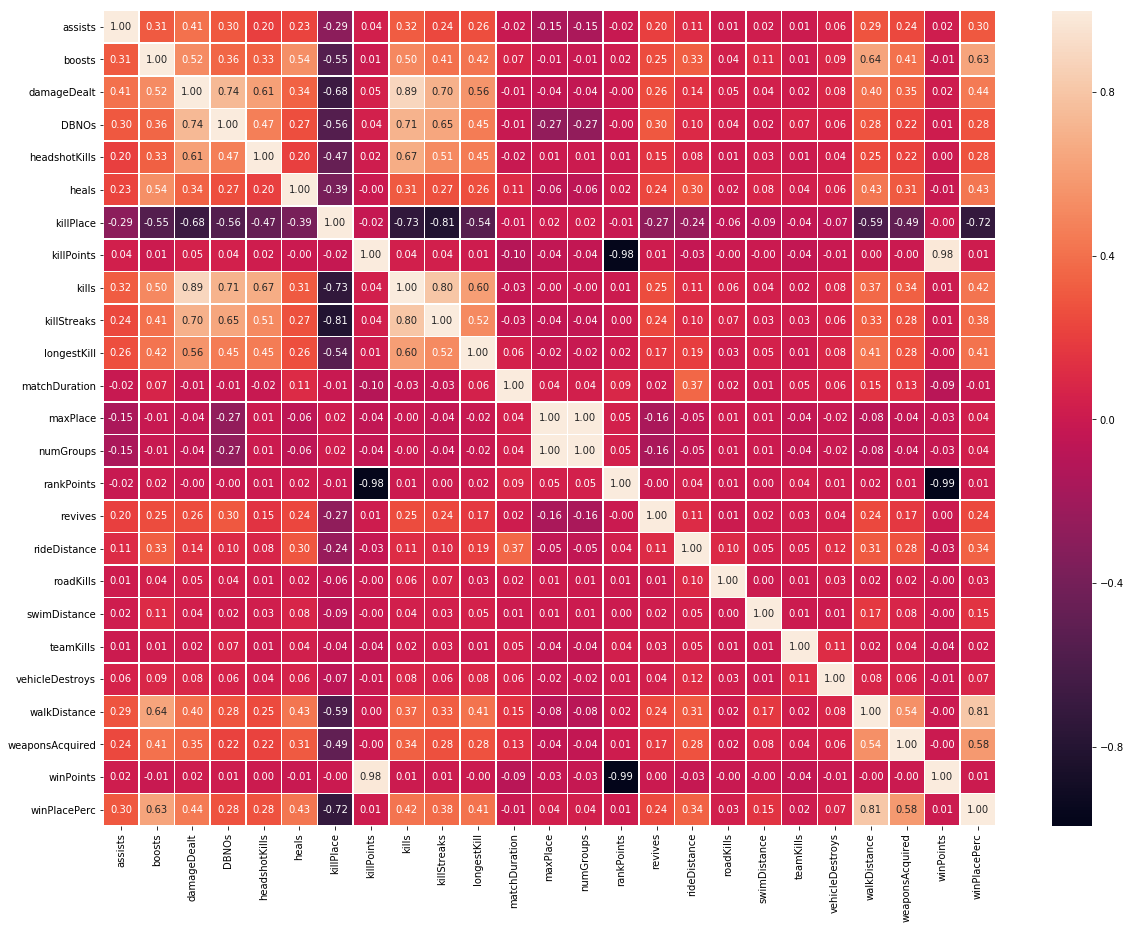

In [7]:
data = train.copy()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True, linewidths=.6, fmt= '.2f',ax=ax)
plt.show()

A first step, after importing and cleaning the data, was to determine the correlations between features in our given data set. More importantly, we wanted to see the correlations between the features and our target feature: winPlacePercentage. 

From the matrix above, it is clear to see that the walkDistance feature, with a score of 0.81, is the feature with the highest correlation with winPlacePercentage. This is a good place to start with our EDA.

## Walking Distance Distribution

In [8]:

print("The average walk distance, in meters, is:", data["walkDistance"].mean())

The average walk distance, in meters, is: 1154.218118648076


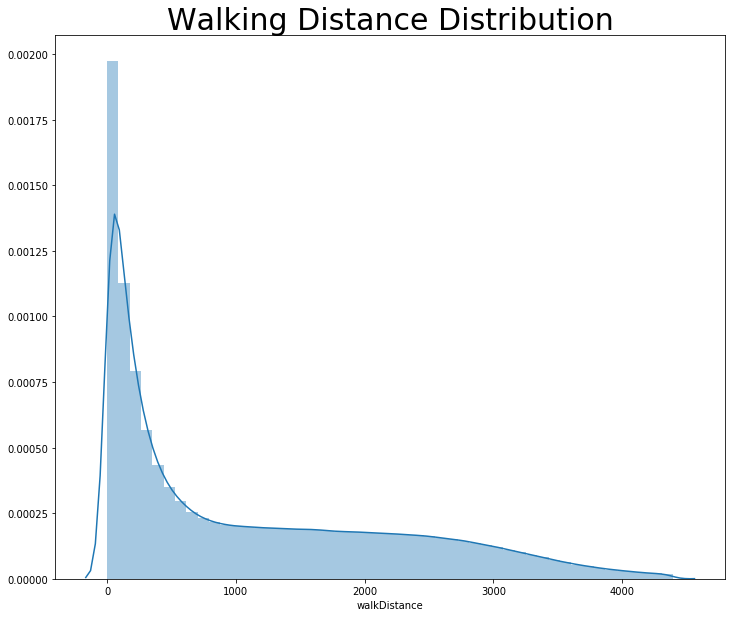

In [9]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(12,10))
plt.title("Walking Distance Distribution",fontsize=30)
sns.distplot(data['walkDistance'])
plt.show()

The correlation between walk distance and the win place percentage fundamentally makes sense. Since the goal of the game is to survive as long as possible, a player with a longer walk distance implies he has been alive for a longer time than most. As a result, the odds of victory for such a player is increased.

## Kills Distribution

0.9.0


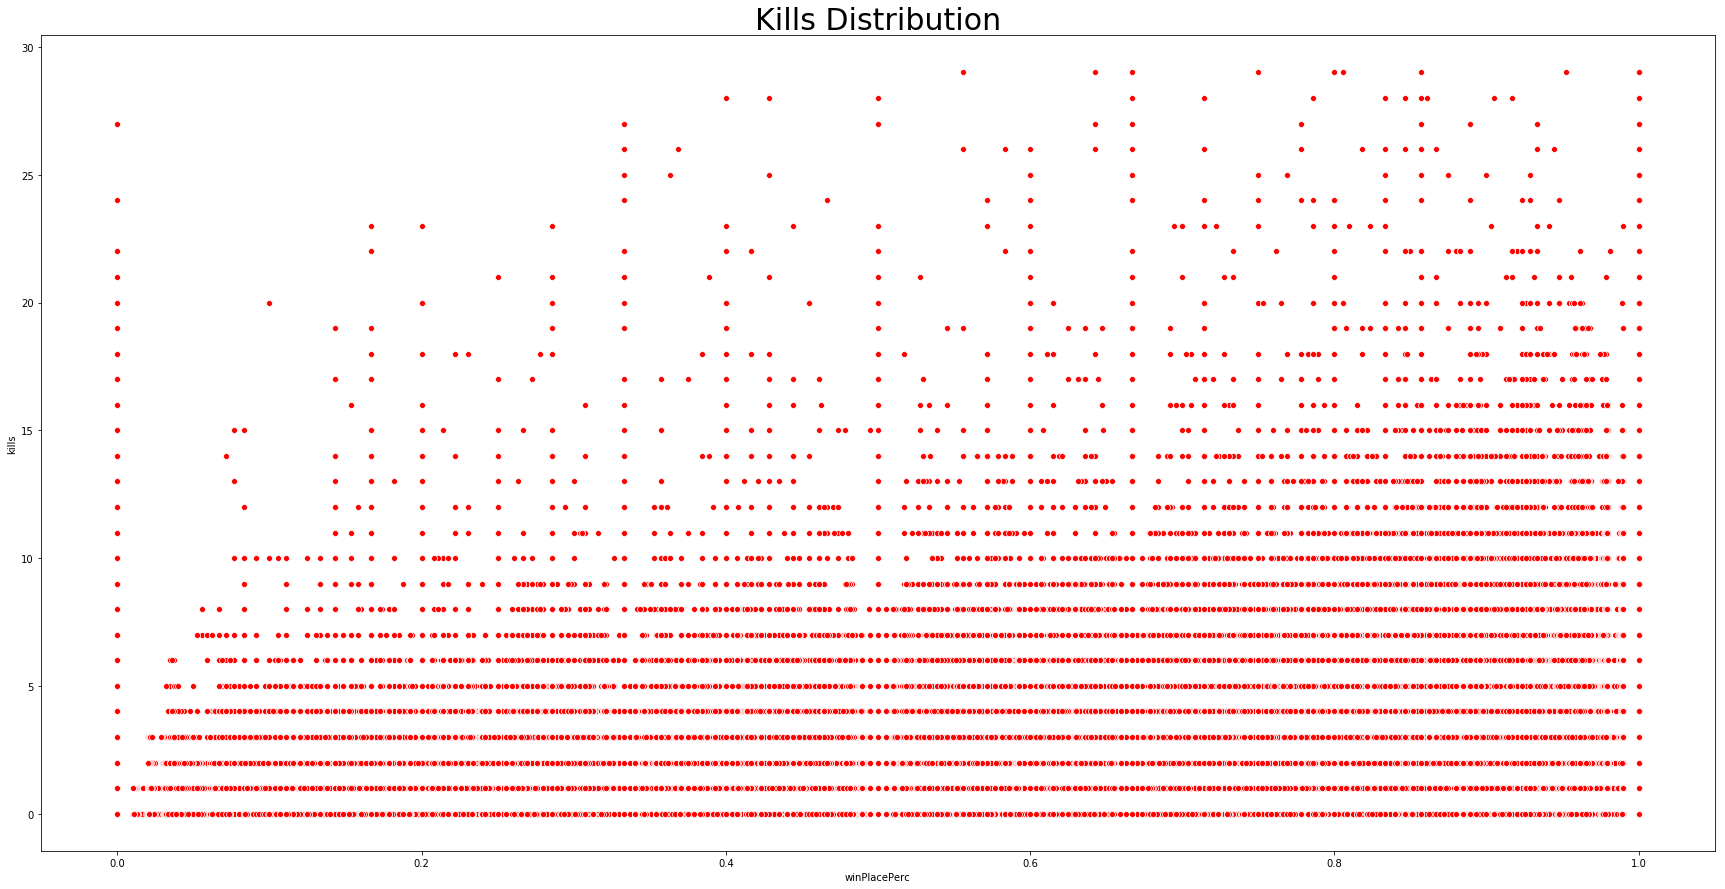

In [10]:
data = train.copy()
import seaborn as sns
print (sns.__version__)
plt.figure(figsize=(30, 15))
plt.title("Kills Distribution", fontsize=30)
sns.scatterplot(x="winPlacePerc", y="kills", data=data[data["kills"] < 30], color="red")
plt.show()

## Kill Distance - Outlier Detection

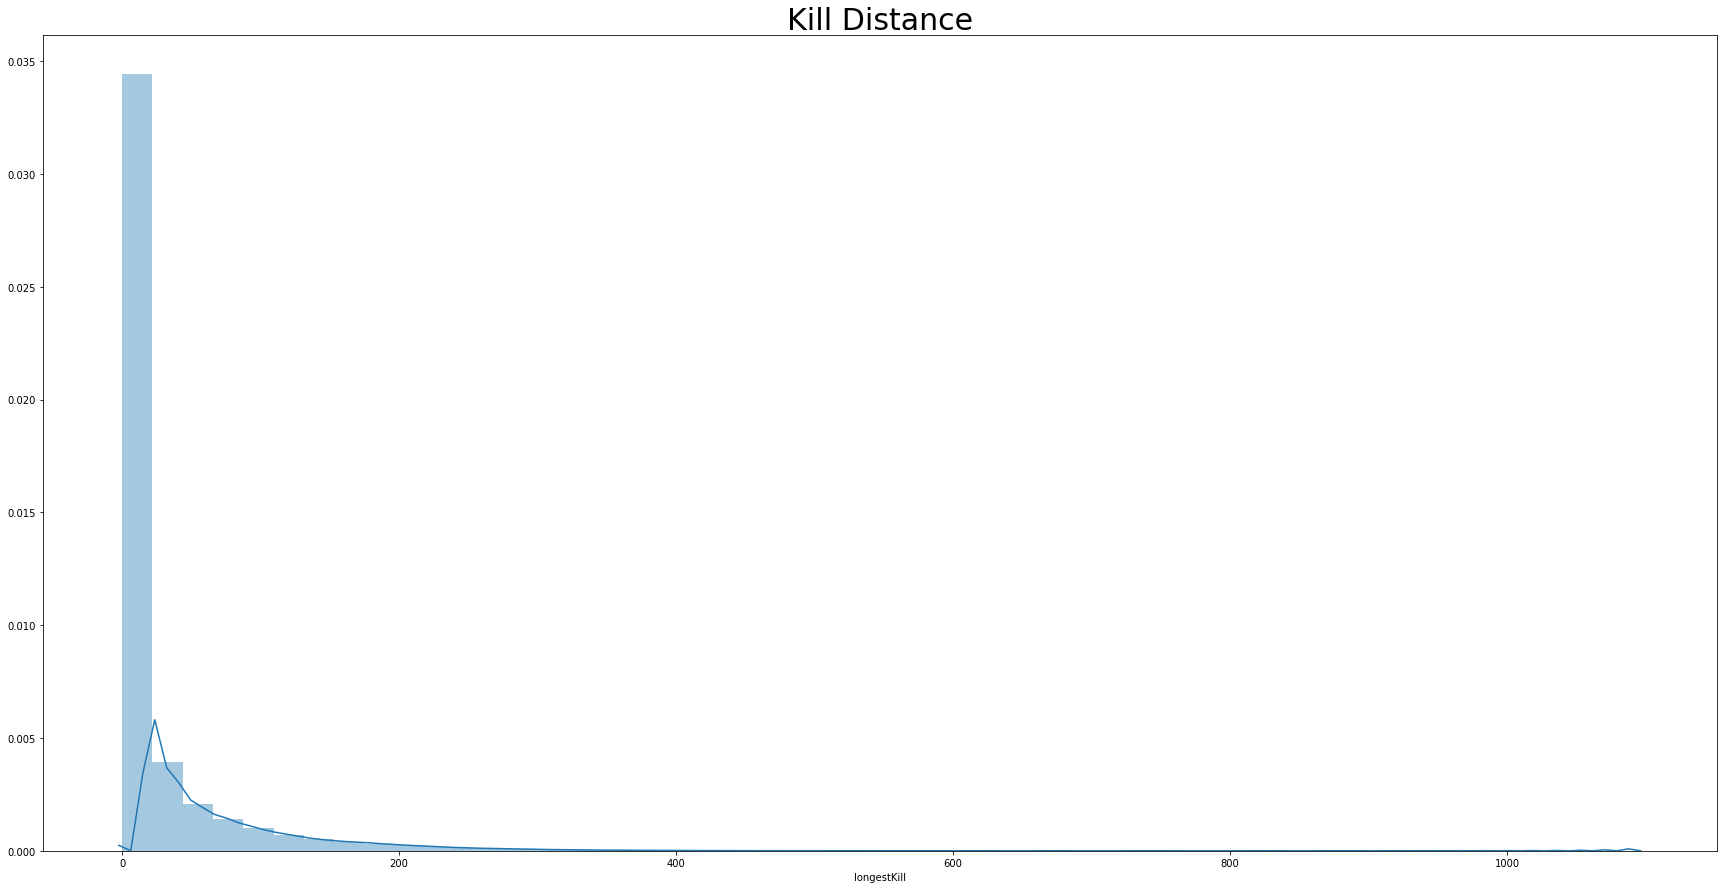

In [11]:
data = train.copy()

plt.figure(figsize=(30, 15))
plt.title("Kill Distance", fontsize = 30)
sns.distplot(data["longestKill"])
plt.show()

On the graph above, we can see some outliers being detected on the far right, just after the 1000 meter mark. Seeing as these data points are anomalies, it gives us an initial suspicions that these players may in fact be cheaters. For the sake of our project, we decided to remove these potential cheaters from our data set.

## Weapons Acquired

In [12]:
print("The average amount of weapons acquired, per player, in a game is", data["weaponsAcquired"].mean())

The average amount of weapons acquired, per player, in a game is 3.6604884454903512


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a6a74a8>]],
      dtype=object)

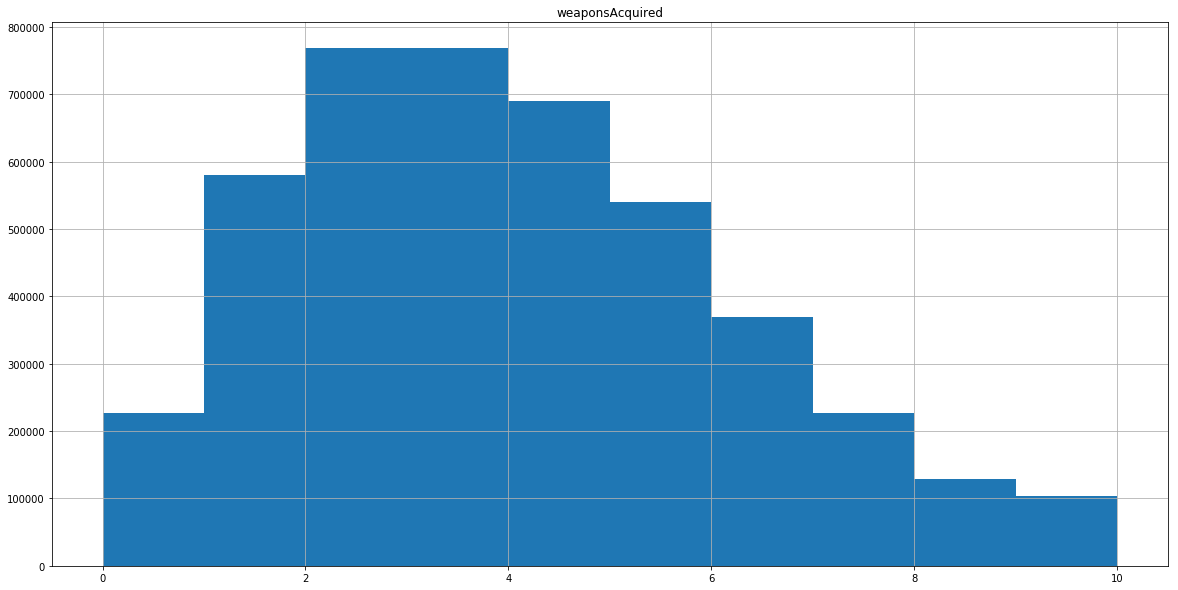

In [13]:
data = train.copy()

data.hist('weaponsAcquired', figsize = (20,10), range=(0, 10))

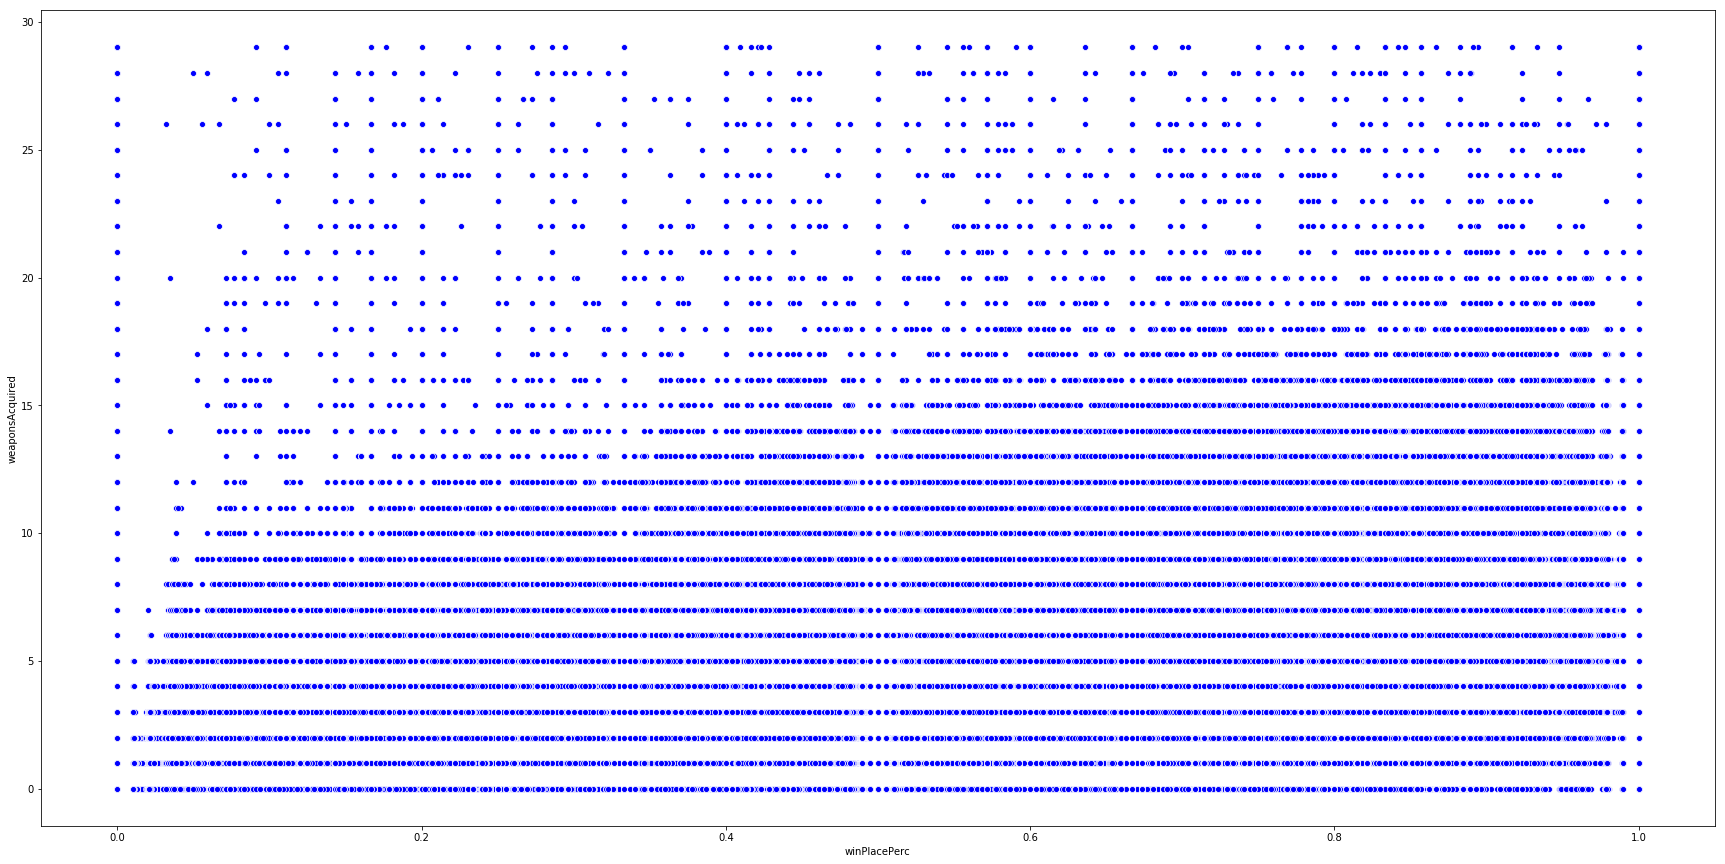

In [14]:
data = train.copy()

plt.figure(figsize=(30, 15))
sns.scatterplot(x="winPlacePerc", y="weaponsAcquired", data=data[data["weaponsAcquired"] < 30], color = "blue")
plt.show()

> # Feature Engineering  <a id="3"></a>

We create a new feature giving us how many players were in a game. Although 100 players is the maximum many games begin with less players and this information will be useful in order to normalize several other features. 

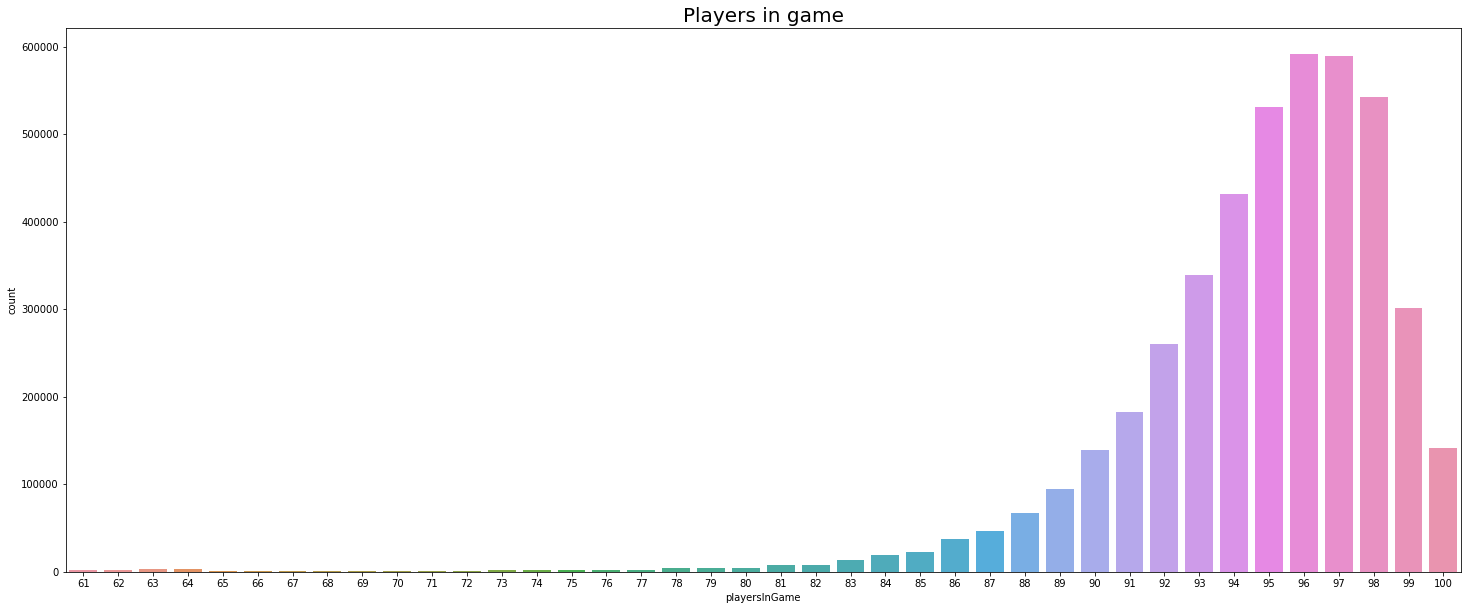

In [15]:
#inspired from other noteboos
train['playersInGame'] = train.groupby('matchId')['matchId'].transform('count')

plt.figure(figsize=(25,10))
sns.countplot(train[train['playersInGame']>60]['playersInGame'])
plt.title("Players in game", fontsize=20)
plt.show()

We use our amount of players in a game in order to normalize several features. The features we decided to normalize are: kills, damageDealt, maxPlace, and matcDuration. If there are less players in your games your kills and damaged dealt should be normalized to account for this. With less players theres a less of a chance you get more kills.

In [16]:
# we will create normalized feautures for several of the features to normalize based on the players in the game
train['killsNorm'] = train['kills']*((100-train['playersInGame'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersInGame'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersInGame'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersInGame'])/100 + 1)

#compare the normalized ones and regular ones
to_show = ['playersInGame','kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:10]

,playersInGame,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,96,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,91,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,98,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,91,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,97,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,95,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,97,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,96,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,97,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,97,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


We add a new feature totalDistance which takes the rideDistance, walkDistance, and swimDistance in order to get a total distance that the player travelled. 

In [17]:
# get the total distance by adding all the dinstances together
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

## Outliers (cheaters) 

We now find outliers and cheaters in our data and remove them from the dataset

We find the players who got kills without even moving. It is very unlikely that a player hasn't moved in a game and got a kill, these players are most likely cheaters, so we remove them. 

In [18]:
train['killsWithoutMoving'] = ((train['kills']>0)&(train['totalDistance'] == 0))
# remove people who got kills without moving
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

We remove the players that have more than 40 kills. These players are probably cheaters since according to pubg.me leaderboards, most of these players came from very early releases of the game when it was still in beta. During this time there were more cheaters and PubG hasnt seen these types of of kill numbers since then. 

In [19]:
train.drop(train[train['kills'] > 40].index, inplace=True)

We now calculate the headshot rate of the players kills. Players who didn't get any headshots will be assigned the value 0. It is very suspect if a player has over 9 kills and a headshot rate of 100%

In [20]:
#people who have 100% headshot with over 9 kills
train['headshot_rate'] = train['headshotKills']/train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 37)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPoints,winPlacePerc,playersInGame,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0,0.8462,93,10.70,1296.84,28.89,1522.61,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,1560,1.0000,96,11.44,1684.80,28.08,1796.08,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,1587,1.0000,98,13.26,1392.30,27.54,1280.10,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,1519,0.9630,95,10.50,1611.75,29.40,1929.90,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1562,1.0000,96,10.40,1409.20,28.08,1473.68,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,0,1.0000,95,11.55,1278.90,29.40,1912.05,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,1468,1.0000,97,10.30,1096.95,27.81,1283.38,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,0,1.0000,93,12.84,1411.33,29.96,1851.10,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1500,1.0000,88,12.32,1288.00,51.52,1397.76,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,0,1.0000,96,13.52,1537.12,50.96,1434.16,2479.8,False,1.0


We display and the distance of players kills. We see most kills tend to be under 200 meters(?). We see a little spike after 1000m which is highly suspect. We remove those players. 

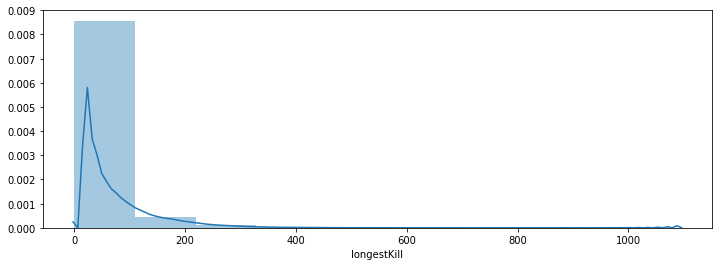

In [21]:
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [22]:
# drop the people who have kills from an insane distance. it makes no sense how they would get these kills. prob cheaters. 
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

We look at the type of matches in pubg. The most common are quad-fpp, duo-fpp, squad, solo-fpp, duo, and solo. fpp means "first-person" as the game has both third-person and first-person perspectives. We then have several other game modes that could be private lobbies and games that are different then the main pubg games. We plan on removing those. 

In [23]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))
print(train['matchType'].value_counts())

There are 16 different Match types in the dataset.
squad-fpp           1756160
duo-fpp              996670
squad                626522
solo-fpp             536612
duo                  313588
solo                 181921
normal-squad-fpp      16211
crashfpp               6287
normal-duo-fpp         5402
flaretpp               2505
normal-solo-fpp        1487
flarefpp                718
normal-squad            453
crashtpp                371
normal-solo             279
normal-duo              192
Name: matchType, dtype: int64


In [24]:
#df.query('matchType != 0')
#train = train[train['matchType'].isin(['squad-fpp duo-fpp squad solo-fpp duo solo'])]
# train.drop(train.loc[(train['matchType'] == "normal-squad-fpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "crashfpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "normal-duo-fpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "flaretpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "normal-solo-fpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "flarefpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "normal-squad")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "crashtpp")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "normal-solo")].index,inplace=True)
# train.drop(train.loc[(train['matchType'] == "normal-duo")].index,inplace=True)

#                      | (train['matchType'] != "duo-fpp" )
#                      | (train['matchType'] != "squad" )
#                      | (train['matchType'] != "solo-fpp" )
#                      | (train['matchType'] != "duo" )
#                      | (train['matchType'] != "solo")].index,inplace=True)

##train = train.drop(train[(train.matchType != "squad-fpp") | (train.matchType !=  "duo-fpp") ].index)
#or "squad" or "solo-fpp" or "duo" or "solo" 
#df = df.drop(df[(df.score < 50) & (df.score > 20)].index
#df.drop(df[df.score < 50].index, inplace=True)

In [25]:
print(train['matchType'].value_counts())
train.shape

squad-fpp           1756160
duo-fpp              996670
squad                626522
solo-fpp             536612
duo                  313588
solo                 181921
normal-squad-fpp      16211
crashfpp               6287
normal-duo-fpp         5402
flaretpp               2505
normal-solo-fpp        1487
flarefpp                718
normal-squad            453
crashtpp                371
normal-solo             279
normal-duo              192
Name: matchType, dtype: int64


(4445378, 37)

We turn groupId and matchId into categorical types in order for the ML algorithms to better process the data. 

In [26]:
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

train.drop(columns=['groupId', 'matchId'], inplace=True)

train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613685,30085
1,827703,32751
2,843396,3143
3,1340261,45260
4,1757597,20531


In [27]:
train.drop(['Id','matchType'], axis=1, inplace=True)
#would want to go back and re add matchtype and mayve only look at 1 match type

We take a look at our cleaned and prepared data set. 

In [28]:
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,playersInGame,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate,groupId_cat,matchId_cat
0,0,0,0.00,0,0,0,60,1241,0,0,...,96,0.00,0.0000,29.12,1358.24,244.8000,False,0.0,613685,30085
1,0,0,91.47,0,0,0,57,0,0,0,...,91,0.00,99.7023,28.34,1936.93,1445.0445,False,0.0,827703,32751
2,1,0,68.00,0,0,0,47,0,0,0,...,98,0.00,69.3600,51.00,1344.36,161.8000,False,0.0,843396,3143
3,0,0,32.90,0,0,0,75,0,0,0,...,91,0.00,35.8610,33.79,1565.24,202.7000,False,0.0,1340261,45260
4,0,0,100.00,0,0,0,45,0,1,1,...,97,1.03,103.0000,99.91,1466.72,49.7500,False,0.0,1757597,20531


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4445378 entries, 0 to 4446965
Data columns (total 35 columns):
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
winPlacePerc          float64
playersInGame         int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
totalDistance         float

> # Machine Learning <a id="4"></a>

We will now do some machine learning on our data to predict the winPlacePerc. We will use Keras, Tensorflow and sklearn. 

In [30]:
X = train.copy()
y = X['winPlacePerc']
X = X.drop(columns = ['winPlacePerc']) 
#X.shape
print("the size of the traning data is {0} x {1} and label size {2}".format(X.shape[0], X.shape[1], y.shape[0]))
#print("the size of the target is {0} ".format(y.shape))
y.head(10)

the size of the traning data is 4445378 x 34 and label size 4445378


0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
5    0.0370
6    0.0000
7    0.7368
8    0.3704
9    0.2143
Name: winPlacePerc, dtype: float64

We split our training data (80:20) to have a cross validation set to fine tune our algorithm without looking at the testing data

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3556302 entries, 122609 to 2826497
Data columns (total 34 columns):
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
playersInGame         int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
totalDistance         float64
killsWithoutMoving    

We encode our labels so that the data is not continuous which causes problems for the ML algorithms.

In [33]:
#this either?
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
# X_train_encoded = ohe.transform(X_train)
# X_test_encoded = ohe.transform(X_test)

Models we no longer are useing have been commented out. We were going to run a basic logistic regression

In [ ]:
# from sklearn.linear_model import LogisticRegression


# bin_clf = LogisticRegression().fit(X_train, y_train_encoded)

/Users/FLSingerman/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/FLSingerman/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metric import mean_absolute_error

# bin_clf_predictions = cross_val_predict(bin_clf, X_train, y_train_encoded, cv=3)
# print('Classifier scores on training set: ')
# print('MAE is {0} '.format(mean_absolute_error(y_train, bin_clf_predictions)))

# #cross_val_score(bin_clf, X_train, y_train_encoded, cv=3, scoring="mean_squared_error")

We run the Support Vector Machine algorithm on our data

In [ ]:
# from sklearn.svm import SVC 

# svm_model_linear = SVC(kernel = 'rbf', C = 1, verbose=True).fit(X_train, y_train_encoded) 
# svm_predictions = svm_model_linear.predict(X_test) 

/Users/FLSingerman/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metric import mean_absolute_error

# svm_train_predictions = cross_val_predict(svm_model_linear, X_train, y_train_encoded, cv=3)
# print('Classifier scores on training set: ')
# print('MAE is {0} '.format(mean_absolute_error(y_train, svm_train_predictions)))

# cross_val_score(m1, X_train, y_train_encoded, cv=3, scoring="mean_squared_error")

In [1]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import cross_val_score


# rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
#                           n_jobs=-1, verbose=True).fit(X_train, y_train_encoded)
# #cross_val_score(m1, X_train, y_train_encoded, cv=3, scoring="mean_squared_error")


In [33]:
# from sklearn.model_selection import cross_val_score, cross_val_predict

# bin_clf_predictions = cross_val_predict(rf, X_train, y_train_encoded, cv=3)

# print('Classifier scores on training set: ')
# print('MAE is {0} '.format(mean_absolute_error(y_train_encoded, bin_clf_predictions)))


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   40.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   34.5s finished


Classifier scores on training set: 
MAE is 1403.7244470251858 


The perceptron model written in keras' sequential API instead of SKLEARN

In [ ]:
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD

model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(34,)))
#model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse',
              optimizer=sgd,
              metrics=['mae'])



In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10)

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_mean_absolute_error'])
plt.title('model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,  BatchNormalization

model2 = Sequential()

model2.add(Dense(32, input_shape=(X_train.shape[1]) , activation='selu'))
model2.add(Dense(64, activation='selu'))
model2.add(Dense(128, activation='selu'))
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='selu'))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='selu'))
model2.add(Dense(32,  activation='selu'))
model2.add(Dense(16, activation='selu'))
model2.add(BatchNormalization())
model2.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [30]:
history = model2.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), validation_steps=20, epochs=10)

Epoch 1/10
3556302/3556302 [==============================] - 558s 157us/step - loss: 0.0208 - mean_absolute_error: 0.1076
Epoch 2/10
3556302/3556302 [==============================] - 548s 154us/step - loss: 0.0187 - mean_absolute_error: 0.1013
Epoch 3/10
3556302/3556302 [==============================] - 536s 151us/step - loss: 0.0174 - mean_absolute_error: 0.0974
Epoch 4/10
3556302/3556302 [==============================] - 518s 146us/step - loss: 0.0164 - mean_absolute_error: 0.0945
Epoch 5/10
3556302/3556302 [==============================] - 500s 141us/step - loss: 0.0153 - mean_absolute_error: 0.0909
Epoch 6/10
3556302/3556302 [==============================] - 543s 153us/step - loss: 0.0155 - mean_absolute_error: 0.0917
Epoch 7/10
3556302/3556302 [==============================] - 544s 153us/step - loss: 0.0143 - mean_absolute_error: 0.0880
Epoch 8/10
3556302/3556302 [==============================] - 518s 146us/step - loss: 0.0138 - mean_absolute_error: 0.0863
Epoch 9/10
35563

In [ ]:
# pred_mod =model2.predict_generator(validation_generator,verbose=1)

# predicted_class_indices=np.argmax(pred_mod,axis=1)

# labels = (X_train.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]



In [31]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error'])


dict_keys(['loss', 'mean_absolute_error'])


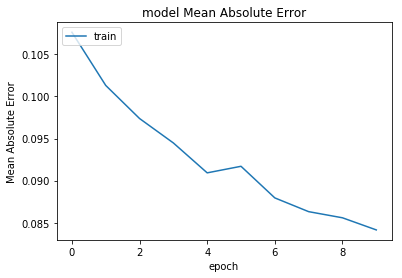

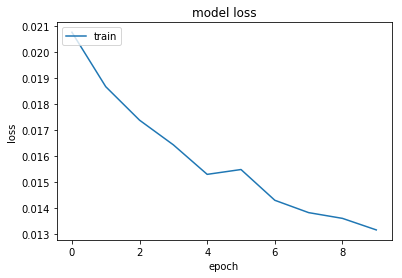

In [35]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_mean_absolute_error'])
plt.title('model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

> # Kaggle Submission <a id="5"></a>

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934174 entries, 0 to 1934173
Data columns (total 35 columns):
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
playersInGame         int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
headshot_rate         float64
totalDistance         float

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3556302 entries, 830827 to 2849104
Data columns (total 34 columns):
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
playersInGame         int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
totalDistance         float64
killsWithoutMoving    

We do all the feature engineering we did earlier to the testing data to prepare it for submission

We choose our best model from above to use in our submission and make a CSV file in the required format (Id, winPlacePerc (prediction)). 

In [127]:

test['playersInGame'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']* (( 100-test['playersInGame']) / 100 + 1)
test['damageDealtNorm'] = test['damageDealt']* (( 100-test['playersInGame']) / 100 + 1)
test['maxPlaceNorm'] = test['maxPlace']* (( 100-train['playersInGame']) / 100 + 1)
test['matchDurationNorm'] = test['matchDuration']* (( 100-test['playersInGame']) / 100 + 1)

test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] =  test['walkDistance'] + test['rideDistance'] + test['swimDistance']

test['killsWithoutMoving'] = ((( test['totalDistance'] == 0) & test['kills'] > 0))

test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes
test.drop(columns=['groupId', 'matchId'], inplace=True)
test.drop(['matchType'], axis=1, inplace=True)





In [108]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934174 entries, 0 to 1934173
Data columns (total 34 columns):
assists               int64
boosts                int64
damageDealt           float64
DBNOs                 int64
headshotKills         int64
heals                 int64
killPlace             int64
killPoints            int64
kills                 int64
killStreaks           int64
longestKill           float64
matchDuration         int64
maxPlace              int64
numGroups             int64
rankPoints            int64
revives               int64
rideDistance          float64
roadKills             int64
swimDistance          float64
teamKills             int64
vehicleDestroys       int64
walkDistance          float64
weaponsAcquired       int64
winPoints             int64
playersInGame         int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
headshot_rate         float64
totalDistance         float

In [130]:
Id = pd.DataFrame({'Id' : test['Id']})

In [131]:
#test_pred = test[to_keep].copy()
test.drop(['Id'], axis=1, inplace=True)
# Fill NaN with 0 (temporary)
test.fillna(0, inplace=True)
test.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,playersInGame,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,headshot_rate,totalDistance,killsWithoutMoving,groupId_cat,matchId_cat
0,0,0,51.46,0,0,0,73,0,0,0,...,92,0.00,55.5768,29.12,2034.72,0.000000,588.0,False,357523,5514
1,0,4,179.10,0,0,2,11,0,2,1,...,96,2.08,186.2640,52.32,1883.44,0.000000,6686.0,False,231759,5268
2,1,0,23.40,0,0,4,49,0,0,0,...,94,0.00,24.8040,28.56,1900.58,0.000000,787.8,False,39107,10783
3,0,0,65.52,0,0,0,54,0,0,0,...,89,0.00,72.7272,49.05,2035.74,0.000000,1812.0,False,634157,2174
4,0,4,330.20,1,2,1,7,0,3,1,...,95,3.15,346.7100,28.84,1392.30,0.666667,2963.0,False,352749,5106


In [133]:
predictions = np.clip(a = model2.predict(test), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : Id['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission.csv", index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    8.3s finished
